***Load the houseprices data from Thinkful's database.
Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.***


In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import RidgeCV,LassoCV,ElasticNetCV


from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")
    
def eval_preds(y_true, y_pred,graph=False):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse}")
    print(f"mae {mae}")
    print(f"mape {mape}")
    
    if graph==True:
        line_pts = [y_true.min(), y_true.max()]
        plt.scatter(y_true, y_pred)
        plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
        plt.xlabel("Actual")
        plt.ylabel("Fit")
        plt.show()


In [3]:
#Loading the dataset and manipulating the variables

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

#deal with missing values
drop_cols=[]
for col in df.columns:
    if df[col].isna().mean()>.4:
        drop_cols=drop_cols+[col]
df_clean=df.drop(columns=drop_cols).dropna()

#manipulate features, ones I don't use are commented out
# df_clean['secondflrexists']=0
# df_clean.loc[df['secondflrsf']>0,'secondflrexists']=1 #can prob drop 2nd fl sq ft
df_clean['yrsbltqared']=df_clean['yearbuilt']*df_clean['yearbuilt']
df_clean['agebuilt']=df_clean['yrsold']-df_clean['yearbuilt']
df_clean['ageremodeled']=df_clean['yrsold']-df_clean['yearremodadd']
df_clean['agebuiltsquared']=df_clean['agebuilt']*df_clean['agebuilt']
df_clean['agebuiltcubed']=df_clean['agebuilt']*df_clean['agebuilt']*df_clean['agebuilt']

# df_clean['logagebuilt']=np.log1p(df_clean['agebuilt'])
# df_clean['logageremodeled']=np.log1p(df_clean['ageremodeled'])

# df_clean['garageage']=df_clean['yrsold']-df_clean['garageyrblt']
# df_clean['garageagesquared']=df_clean['garageage']**2

####
df_clean['overallqualsquared']=df_clean['overallqual']*df_clean['overallqual']
df_clean['overallqualcubed']=df_clean['overallqual']*df_clean['overallqual']*df_clean['overallqual']
#df_clean['logqualsquared']=np.log(df_clean['overallqualsquared'])
# df_clean['logqual']=np.log(df_clean['overallqual'])
# df_clean['squaredlogqual']=df_clean['logqual']*df_clean['logqual']

df_clean['grlivareasquared']=df_clean['grlivarea']*df_clean['grlivarea']
# df_clean['loggrlivarea']=np.log(df_clean['grlivarea'])
# df_clean['squaredlogarea']=df_clean['loggrlivarea']*df_clean['loggrlivarea']


df_clean['ageremodeledsquared']=df_clean['ageremodeled']*df_clean['ageremodeled']
# df_clean['ageremodeledcubed']=df_clean['ageremodeled']*df_clean['ageremodeled']

# df_clean['totalsf']=df_clean['totalbsmtsf']+df_clean['grlivarea']
# df_clean['qual_totalsf']=df_clean['totalsf']*df_clean['overallqual']

df_clean['lotareasquared']=df_clean['lotarea']*df_clean['lotarea']

#making partial,centralair and the neighborhood a binary variable
niceneighborhoods=['NridgHt', 'NoRidge', 'Somerst', 'Timber', 'Veenker', 'StoneBr']
goodneighborhoods=['ClearCr','Crawfor','CollgCr','Gilbert','Blmngtn','SawyerW','NWAmes']

df_clean['nicehood']=0
df_clean.loc[df_clean.neighborhood.isin(niceneighborhoods),'nicehood']=1
df_clean['hoodrank']=0
df_clean.loc[df_clean.neighborhood.isin(goodneighborhoods),'hoodrank']=1
df_clean.loc[df_clean.neighborhood.isin(niceneighborhoods),'hoodrank']=2
df_clean['goodhood']=0
df_clean.loc[df_clean.neighborhood.isin(goodneighborhoods),'goodhood']=1

#Making binary cats ints
df_clean['sale_partial']=0
df_clean.loc[df_clean.salecondition=='Partial','sale_partial']=1
df_clean['centralairint']=0
df_clean.loc[df_clean.centralair=='Y','centralairint']=1
# df_clean['pavedstreet']=0
# df_clean.loc[df_clean.salecondition=='Pave','pavedstreet']=1


#one hot encoding neighborhood
#df_clean = pd.concat([df_clean,pd.get_dummies(df_clean.neighborhood, prefix="hood", drop_first=True)], axis=1)

In [4]:
#Dropping outliers of high leveridge
df_clean=df_clean.drop([314,523,1298,452])

In [5]:
#Setting up the feature selection and OLS model

# Right hashtag indicates vars I'm iffy on
cat_cols=['nicehood','goodhood','centralairint','salepartial']
num_cols=['overallqual',
          'overallqualsquared',
          'overallqualcubed',
          'grlivarea',
          'totalbsmtsf',
          'garagearea',
          'lotarea',
          'lotareasquared',
          'ageremodeled',
          'ageremodeledsquared',
          'agebuilt',
          'agebuiltsquared',
          'bedroomabvgr']

X = df_clean[['overallqual',
              'overallqualsquared',#
              'overallqualcubed',#
              'grlivarea',
#               'grlivareasquared',#
#               'loggrlivarea',#
               'totalbsmtsf',
               #'totalsf',#
               'garagearea', 
               'lotarea',
              'lotareasquared',
              'nicehood',
              'goodhood',
#               'hoodrank',#
               'ageremodeled',
               'ageremodeledsquared',
#               'ageremodeledcubed',#
#               'logageremodeled',##
               'agebuilt',
               'agebuiltsquared',
#               'logagebuilt',##
               'sale_partial',#
              'centralairint',
#               'newsale',#
              'bedroomabvgr',#
#                'yrsold',
              ]]
y = df_clean.saleprice
y_log=np.log(y)

In [6]:
#splitting the data into a training/test set
X_train, X_test, y_log_train, y_log_test=train_test_split(X,y_log,test_size=.2,random_state=1)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
results_log = sm.OLS(y_log_train, X_train_const).fit()
print(results_log.summary())
y_log_preds=results_log.predict(X_test_const)
y_log_train_preds=results_log.predict(X_train_const)

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     393.1
Date:                Thu, 03 Sep 2020   Prob (F-statistic):               0.00
Time:                        04:18:40   Log-Likelihood:                 510.81
No. Observations:                 872   AIC:                            -985.6
Df Residuals:                     854   BIC:                            -899.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.1228    

In [7]:
print("Mean absolute error of the training set is: {}".format(mean_absolute_error(y_log_train, y_log_train_preds)))
print("Mean squared error of the training set is: {}".format(mse(y_log_train, y_log_train_preds)))
print("Root mean squared error of the training set is: {}".format(rmse(y_log_train, y_log_train_preds)))
print("Mean absolute percentage error of the training set is: {}".format(np.mean(np.abs((y_log_train - y_log_train_preds) / y_log_train)) * 100))


Mean absolute error of the training set is: 0.09748812970663243
Mean squared error of the training set is: 0.018143047315407477
Root mean squared error of the training set is: 0.13469612954872712
Mean absolute percentage error of the training set is: 0.8150226606774564


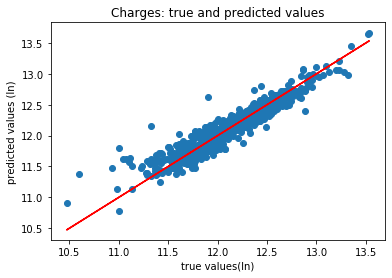

In [8]:
plt.scatter(y_log_train, y_log_train_preds)
plt.plot(y_log_train, y_log_train, color="red")
plt.xlabel("true values(ln)")
plt.ylabel("predicted values (ln)")
plt.title("Charges: true and predicted values")
plt.show()
# y_test= np.exp(y_log_train)
# y_preds=np.exp(y_log_train_preds)

# print(mean_squared_log_error(y_test, y_preds))

These features seem to work well. On to comparing different models with cross validation:

***Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!***

In [9]:
#First, OLS:
linear = LinearRegression()
linear.fit(X_train, y_log_train)
print(cross_val_score(linear, X_train, y_log_train, cv=5).mean())

0.8785830211587491


In [10]:
#scale the features
ct = ColumnTransformer(
    [
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)
ct.fit(X_train)

X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)
X_test=pd.DataFrame(X_test_trans)
X_train=pd.DataFrame(X_train_trans)


In [11]:
# Lasso
grid = {"alpha": [0,.0000001,.000001,.00001,0.0001,]}

lasso_cv = GridSearchCV(Lasso(), grid, verbose=1, cv=5)
lasso_cv.fit(X_train, y_log_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
print(f"best score: {lasso_cv.best_score_}")
print(lasso_cv.best_estimator_.coef_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


selected alpha: 0
best score: 0.8786312584399649
[ 0.21054604 -0.23672488  0.13481478  0.1437957   0.06016172  0.0197771
  0.0750275  -0.03476093 -0.09189081  0.03244838  0.0512501  -0.07351961
 -0.00916044  0.11740119  0.06104581  0.04570268  0.16652398]


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


Seems like it likes alpha=0, ie. OLS

In [12]:
# Ridge
grid = {"alpha": [.05,.06,.07,.08,.09,.1]}

ridge_cv = GridSearchCV(Ridge(), grid, verbose=1, cv=5)
ridge_cv.fit(X_train, y_log_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {ridge_cv.best_estimator_.alpha}")
print(f"best score: {ridge_cv.best_score_}")
ridge_cv.best_estimator_.coef_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
selected alpha: 0.07
best score: 0.8787743899507736


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


array([ 0.37289817, -0.57249318,  0.30935702,  0.14414899,  0.05989351,
        0.02025709,  0.07492205, -0.03477078, -0.09433395,  0.03500354,
        0.04794583, -0.0714929 , -0.00960169,  0.12033487,  0.06268863,
        0.04468024,  0.16178173])

In [13]:
#ElasticNet
grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "l1_ratio": [0.25, 0.5, 0.75, 1.0],
}

elastic = GridSearchCV(ElasticNet(), grid)
elastic.fit(X_train, y_log_train)

print(f"best score: {elastic.best_score_}")
elastic.best_params_

best score: 0.8783472084858509


{'alpha': 0.001, 'l1_ratio': 0.25}

**Seems like my best bet is ridge with a lambda/alpha of .07**

Putting it to the 'test':

In [14]:
ridge = Ridge(alpha=.07)
ridge.fit(X_train, y_log_train)
print(f"Ridge Test R^2: {ridge.score(X_test, y_log_test)}")
y_preds=ridge.predict(X_test)
print("Mean absolute error of the test predictions are: {}".format(mean_absolute_error(y_log_test, y_preds)))
print("Mean squared error of the test predictions are: {}".format(mse(y_log_test, y_preds)))
print("Root mean squared error of the test predictions are: {}".format(rmse(y_log_test, y_preds)))
print("Mean absolute percentage error of the test predictions are: {}".format(np.mean(np.abs((y_log_test - y_preds) / y_log_test)) * 100))


Ridge Test R^2: 0.8859078792693609
Mean absolute error of the test predictions are: 0.09026331464284909
Mean squared error of the test predictions are: 0.01564710068713466
Root mean squared error of the test predictions are: 0.1250883715104432
Mean absolute percentage error of the test predictions are: 0.7497294155304829


Remember that y_preds are still in logs

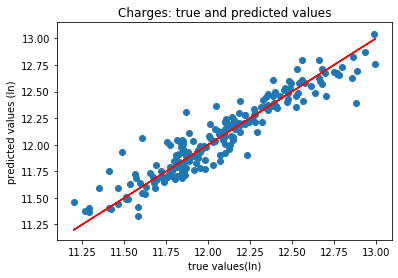

In [15]:
plt.scatter(y_log_test, y_preds)
plt.plot(y_log_test, y_log_test, color="red")
plt.xlabel("true values(ln)")
plt.ylabel("predicted values (ln)")
plt.title("Charges: true and predicted values")
plt.show()

***So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.***


Probably the best measure of the price level of the general housing market is the case-shiller price index. Here I import one for Iowa. I don't think it's inflation adjusted, so it should also control for that general price inflation. In this way, it's a good replacement for a year sold type variable. (Ames is where our data is)

In [16]:
file_path='/Users/jamesmoss/Documents/GitHub/Notes and Exercises/IndividualExercises/Week6/IASTHPI.csv'
CS_index=pd.read_csv(file_path)

In [17]:
CS_index['DATE']=pd.to_datetime(CS_index['DATE'])
CS_index['quarter']=CS_index['DATE'].dt.quarter
CS_index['year']=CS_index['DATE'].dt.year
CS_index=CS_index.drop(columns='DATE')

In [18]:
CS_index.head()

,IASTHPI,quarter,year
0,238.86,1,2006
1,240.22,2,2006
2,241.62,3,2006
3,243.59,4,2006
4,244.43,1,2007


In [19]:
pd.set_option('display.max_columns', 500)
df_clean.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,yrsbltqared,agebuilt,ageremodeled,agebuiltsquared,agebuiltcubed,overallqualsquared,overallqualcubed,grlivareasquared,ageremodeledsquared,lotareasquared,nicehood,hoodrank,goodhood,sale_partial,centralairint
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,4012009,5,5,25,125,49,343,2924100,25,71402500,0,1,1,0,1
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,3904576,31,31,961,29791,36,216,1592644,961,92160000,1,2,0,0,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,4004001,7,6,49,343,49,343,3189796,36,126562500,0,1,1,0,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,3667225,91,36,8281,753571,49,343,2948089,1296,91202500,0,1,1,0,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,4000000,8,8,64,512,64,512,4831204,64,203347600,1,2,0,0,1


In [20]:
df_clean['year']=df_clean['yrsold']
df_clean['MONTH']=df_clean['mosold']
df_clean['DATE'] = pd.to_datetime(df_clean[['year', 'MONTH']].assign(DAY=1))
df_clean['quarter'] =df_clean['DATE'].dt.quarter

In [21]:
merged = df_clean.merge(CS_index,how='left', on=['year','quarter'])
#merged.head()

Do a quick analysis with the new data, copying code from above:

In [22]:
cat_cols=['nicehood','goodhood','centralairint','salepartial']
num_cols=['overallqual',
          'overallqualsquared',
          'overallqualcubed',
          'grlivarea',
          'totalbsmtsf',
          'garagearea',
          'lotarea',
          'lotareasquared',
          'ageremodeled',
          'ageremodeledsquared',
          'agebuilt',
          'agebuiltsquared',
          'bedroomabvgr',
          'IASTHPI'
          ]

X = merged[['overallqual',
              'overallqualsquared',#
              'overallqualcubed',#
              'grlivarea',
#               'grlivareasquared',#
#               'loggrlivarea',#
               'totalbsmtsf',
               #'totalsf',#
               'garagearea', 
               'lotarea',
              'lotareasquared',
              'nicehood',
              'goodhood',
#               'hoodrank',#
               'ageremodeled',
               'ageremodeledsquared',
#               'ageremodeledcubed',#
#               'logageremodeled',##
               'agebuilt',
               'agebuiltsquared',
#               'logagebuilt',##
               'sale_partial',#
              'centralairint',
#               'newsale',#
              'bedroomabvgr',#
              'IASTHPI'
              ]]
# merged['pricedeflated']=merged['saleprice']/(merged['IASTHPI']/merged['IASTHPI'].mean())
y = merged.saleprice
y_log=np.log(y)

#splitting the data into a training/test set
X_train, X_test, y_log_train, y_log_test=train_test_split(X,y_log,test_size=.2,random_state=1)
ct = ColumnTransformer(
    [
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)
ct.fit(X_train)

X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)
X_test=pd.DataFrame(X_test_trans)
X_train=pd.DataFrame(X_train_trans)
# Ridge
grid = {"alpha": [.05,.06,.07,.08,.09,.1]}

ridge_cv = GridSearchCV(Ridge(), grid, verbose=1, cv=5)
ridge_cv.fit(X_train, y_log_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {ridge_cv.best_estimator_.alpha}")
print(f"best score: {ridge_cv.best_score_}")
ridge_cv.best_estimator_.coef_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
selected alpha: 0.07
best score: 0.8788454194639896


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


array([ 0.37142076, -0.56988024,  0.30788239,  0.14430178,  0.05960589,
        0.01978629,  0.07555732, -0.0348637 , -0.09253799,  0.03367654,
        0.04560812, -0.06980858, -0.00946717,  0.00537248,  0.11952665,
        0.06206598,  0.04691466,  0.16154889])

In [23]:
ridge = Ridge(alpha=.07)
ridge.fit(X_train, y_log_train)
print(f"Ridge Test R^2: {ridge.score(X_test, y_log_test)}")
y_preds=ridge.predict(X_test)
print("Mean absolute error of the test predictions are: {}".format(mean_absolute_error(y_log_test, y_preds)))
print("Mean squared error of the test predictions are: {}".format(mse(y_log_test, y_preds)))
print("Root mean squared error of the test predictions are: {}".format(rmse(y_log_test, y_preds)))
print("Mean absolute percentage error of the test predictions are: {}".format(np.mean(np.abs((y_log_test - y_preds) / y_log_test)) * 100))


Ridge Test R^2: 0.8857093252526314
Mean absolute error of the test predictions are: 0.09018266724861186
Mean squared error of the test predictions are: 0.015674331267754135
Root mean squared error of the test predictions are: 0.12519716956766289
Mean absolute percentage error of the test predictions are: 0.7489872388530068


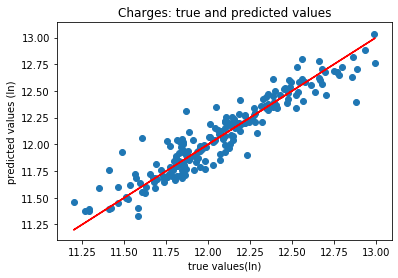

In [24]:
plt.scatter(y_log_test, y_preds)
plt.plot(y_log_test, y_log_test, color="red")
plt.xlabel("true values(ln)")
plt.ylabel("predicted values (ln)")
plt.title("Charges: true and predicted values")
plt.show()

It doesn't seems like the addition of a housing pricd index made a large difference. This might be because either 1)Ames is relatively isolated from the wider effects of the housing market 2)The range of time that the data takes place in is relatively narrow, not allowing for much variance in the index (although it does cover some of the housing market crash of 2008. 3) The effect of the housing market is already captured by variables included. I think it's probably a combination of the first two. Ames is largely a college town, so you wouldn't see too much of the same reliance on cyclical housing prices as you would in cities that aren't 30% college.

For further analysis, I would include a measure of the size of Iowa State University, as well as its yearly/quarterly budget for real estate.